### Predictive Model for Late Returns


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load and prepare data
books = pd.read_csv('/Users/hpourmand/Desktop/Data Analyst Sample/cleaned_books.csv')
libraries = pd.read_csv('/Users/hpourmand/Desktop/Data Analyst Sample/cleaned_libraries.csv')
checkouts = pd.read_csv('/Users/hpourmand/Desktop/Data Analyst Sample/cleaned_checkouts.csv')
customers = pd.read_csv('/Users/hpourmand/Desktop/Data Analyst Sample/cleaned_customers.csv')

# Convert date columns to datetime
checkouts['date_checkout'] = pd.to_datetime(checkouts['date_checkout'])
checkouts['date_returned'] = pd.to_datetime(checkouts['date_returned'])

# Merge datasets
checkouts_with_books = checkouts.merge(books, left_on='id', right_on='id')
data = checkouts_with_books.merge(customers, left_on='patron_id', right_on='id')

# Feature Engineering
data['days_late'] = (data['date_returned'] - data['date_checkout']).dt.days - 28
data['is_late'] = data['days_late'] > 0
features = ['library_id', 'categories', 'gender', 'education', 'days_late']
target = 'is_late'

# Define features and target variable
X = data[features]
y = data[target]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['days_late']),
        ('cat', OneHotEncoder(), ['library_id', 'categories', 'gender', 'education'])
    ]
)

# Create pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


 #Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       323
        True       1.00      0.92      0.96        38

    accuracy                           0.99       361
   macro avg       1.00      0.96      0.98       361
weighted avg       0.99      0.99      0.99       361



### Identifying High-Risk Patrons


In [2]:
import pandas as pd


# Calculate the difference between returned date and checkout date
checkouts['days_late'] = (checkouts['date_returned'] - checkouts['date_checkout']).dt.days - 28

# Determine if the book was returned late
checkouts['is_late'] = checkouts['days_late'] > 0


# Merge checkouts with customers to include demographic information
try:
    merged_data = pd.merge(checkouts, customers, left_on='patron_id', right_on='id')
except KeyError as e:
    print(f"Merge failed. KeyError: {e}")
    print("Check if the 'patron_id' column in checkouts and 'id' column in customers are present.")
    raise

# Calculate late return rate and average days late by patron
patron_stats = checkouts.groupby('patron_id').agg(
    late_return_rate=('is_late', 'mean'),
    avg_days_late=('days_late', 'mean')
)

# Identify high-risk patrons
# You can set your own thresholds for what constitutes 'high risk'
late_return_threshold = 0.5  # Example: 50% late return rate
avg_days_late_threshold = 10  # Example: More than 10 days on average late

high_risk_patrons = patron_stats[
    (patron_stats['late_return_rate'] > late_return_threshold) &
    (patron_stats['avg_days_late'] > avg_days_late_threshold)
]

# Merge high-risk patrons with customer details
high_risk_patrons = high_risk_patrons.reset_index()
high_risk_patrons = pd.merge(high_risk_patrons, customers, left_on='patron_id', right_on='id')

# Output the results
print("High-Risk Patrons:")
print(high_risk_patrons[['patron_id', 'late_return_rate', 'avg_days_late', 'gender', 'education']])


High-Risk Patrons:
                            patron_id  late_return_rate  avg_days_late  \
0    006ec5b8f21fba3c5da132ee0f385a69               1.0           85.0   
1    00a03fa2d7f78b3a01a62beeb666cc34               1.0           27.0   
2    043f788a782b8933b5f208efefefb247               1.0           66.0   
3    0701c483239ce3146dc0103e67a1f589               1.0           35.0   
4    077af1a657c88e5ab8ac0cadfa64b3a0               1.0          146.0   
..                                ...               ...            ...   
113  f8ef7fe962217fc3a036969bf432b82c               1.0          116.0   
114  f94b09a093db5478467f695a606b8a18               1.0          121.0   
115  fcb744f47152acb7e40eb6cdadb0bc61               1.0          133.0   
116  fce6305084f5d1bb2ce00b382c2b8fd2               1.0          106.0   
117  fdad135846a966f69f100f345610015c               1.0           45.0   

     gender        education  
0      MALE      High School  
1    FEMALE           Others  

### Seasonal Trends in Checkouts and Returns

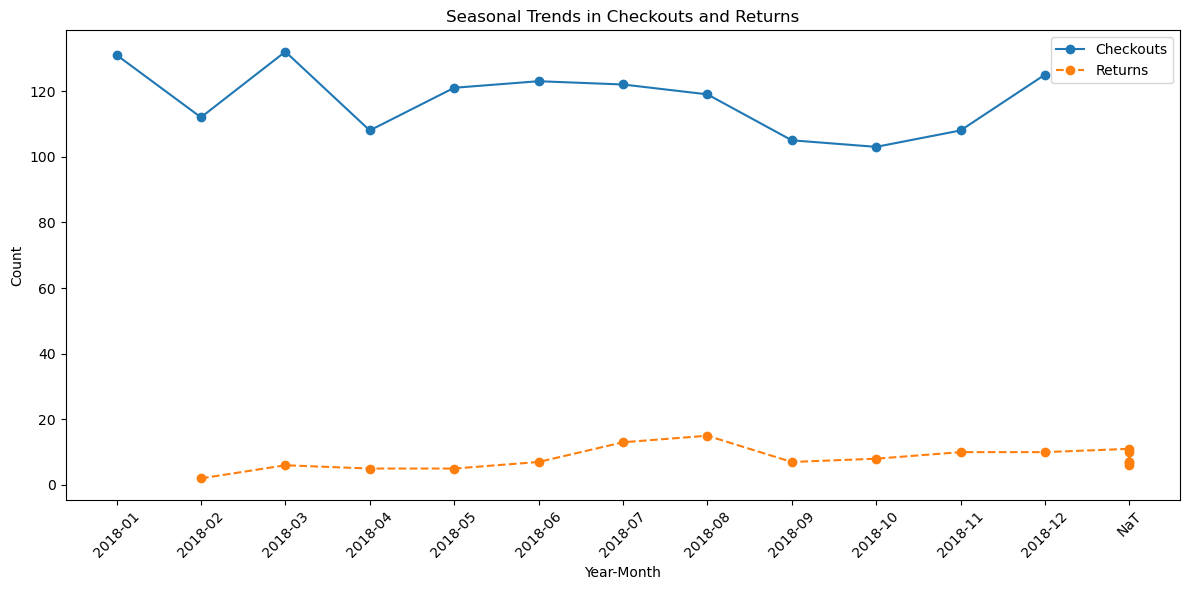

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


# Extract year and month from dates
checkouts['checkout_year_month'] = checkouts['date_checkout'].dt.to_period('M')
checkouts['return_year_month'] = checkouts['date_returned'].dt.to_period('M')

# Aggregate number of checkouts and returns by year and month
checkouts_per_month = checkouts.groupby('checkout_year_month').size()
returns_per_month = checkouts[checkouts['is_late']].groupby('return_year_month').size()

# Convert to DataFrame for easier plotting
checkouts_df = checkouts_per_month.reset_index(name='number_of_checkouts')
returns_df = returns_per_month.reset_index(name='number_of_returns')

# Merge the dataframes
seasonal_trends = pd.merge(checkouts_df, returns_df, left_on='checkout_year_month', right_on='return_year_month', how='outer')

# Plot the seasonal trends
plt.figure(figsize=(12, 6))
plt.plot(seasonal_trends['checkout_year_month'].astype(str), seasonal_trends['number_of_checkouts'], marker='o', label='Checkouts')
plt.plot(seasonal_trends['checkout_year_month'].astype(str), seasonal_trends['number_of_returns'], marker='o', label='Returns', linestyle='--')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title('Seasonal Trends in Checkouts and Returns')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
